# Viral Tweets Prediction

The goal of this competition is to develop a machine learning model to predict the virality level of each tweet based on attributes such as tweet content, media attached to the tweet, and date/time published.

In [1]:

import pandas as pd
import numpy as np


import random
import timeit
import math 
import collections 

# surpress warnings
import warnings
warnings.filterwarnings('ignore')

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='darkgrid', color_codes=True)
plt.style.use('fivethirtyeight')
%matplotlib inline

## Load Data

In [2]:
# Load training datasets
train_tweets = pd.read_csv(r"C:\Users\johnl\Documents\Tweets\Dataset\Tweets\train_tweets.csv")
train_tweets_vectorized_media = pd.read_csv(r"C:\Users\johnl\Documents\Tweets\Dataset\Tweets\train_tweets_vectorized_media.csv")
train_tweets_vectorized_text = pd.read_csv(r"C:\Users\johnl\Documents\Tweets\Dataset\Tweets\train_tweets_vectorized_text.csv")
# Load test datasets
test_tweets = pd.read_csv(r"C:\Users\johnl\Documents\Tweets\Dataset\Tweets\test_tweets.csv")
test_tweets_vectorized_media = pd.read_csv(r"C:\Users\johnl\Documents\Tweets\Dataset\Tweets\test_tweets_vectorized_media.csv")
test_tweets_vectorized_text = pd.read_csv(r"C:\Users\johnl\Documents\Tweets\Dataset\Tweets\test_tweets_vectorized_text.csv")

                                

In [3]:
pd.__version__

'1.2.4'

In [3]:
# Load user dataset
users = pd.read_csv(r'C:\Users\johnl\Documents\Tweets\Dataset\Users\users.csv')
user_vectorized_descriptions = pd.read_csv(r'C:\Users\johnl\Documents\Tweets\Dataset\Users\user_vectorized_descriptions.csv')
user_vectorized_profile_images = pd.read_csv(r'C:\Users\johnl\Documents\Tweets\Dataset\Users\user_vectorized_profile_images.csv')

## Data Shape

In [5]:
print("train_tweets shape: " + str(train_tweets.shape))
print("train_tweets_vectorized_media shape: " + str(train_tweets_vectorized_media.shape))
print("train_tweets_vectorized_text shape: " + str(train_tweets_vectorized_text.shape))

print("test_tweets shape: " + str(test_tweets.shape))
print("test_tweets_vectorized_media shape: " + str(test_tweets_vectorized_media.shape))
print("test_tweets_vectorized_text shape: " + str(test_tweets_vectorized_text.shape))

print("users shape: " +str(users.shape) )
print("user_vectorized_descriptions shape: " + str(user_vectorized_descriptions.shape))
print("user_vectorized_profile_images shape: " + str(user_vectorized_profile_images.shape))


train_tweets shape: (29625, 14)
train_tweets_vectorized_media shape: (21010, 2050)
train_tweets_vectorized_text shape: (29625, 769)
test_tweets shape: (12697, 13)
test_tweets_vectorized_media shape: (8946, 2050)
test_tweets_vectorized_text shape: (12697, 769)
users shape: (52, 11)
user_vectorized_descriptions shape: (52, 769)
user_vectorized_profile_images shape: (52, 2049)


# Exploratory Data Analysis

In [4]:
# what train_tweets looks like
train_tweets.head()

,tweet_id,tweet_user_id,tweet_created_at_year,tweet_created_at_month,tweet_created_at_day,tweet_created_at_hour,tweet_hashtag_count,tweet_url_count,tweet_mention_count,tweet_has_attachment,tweet_attachment_class,tweet_language_id,tweet_topic_ids,virality
0,34698,10,2015,12,5,3,2.0,1.0,0.0,False,C,0,"['36', '36', '36', '36', '36', '36', '37', '37...",3
1,24644,4,2020,6,19,0,0.0,1.0,0.0,False,C,0,"['43', '78', '79', '80', '80', '89', '98', '99...",3
2,36321,54,2019,6,2,15,2.0,3.0,0.0,True,A,0,"['79', '80', '98', '98', '98', '99', '99', '10...",1
3,2629,42,2020,9,6,17,0.0,1.0,1.0,True,A,0,"['43', '79', '80', '98', '99', '99', '79', '80']",2
4,28169,32,2020,11,4,17,2.0,1.0,0.0,True,A,0,"['79', '80', '98', '99', '43', '89']",2


Our target is the virality column <br>
tweet_topic_ids contains arrays so we will have to seperate them <br>
Two ids per row 

In [7]:
# what train_tweets_vectorized_media looks like
train_tweets_vectorized_media.head()

,media_id,tweet_id,img_feature_0,img_feature_1,img_feature_2,img_feature_3,img_feature_4,img_feature_5,img_feature_6,img_feature_7,...,img_feature_2038,img_feature_2039,img_feature_2040,img_feature_2041,img_feature_2042,img_feature_2043,img_feature_2044,img_feature_2045,img_feature_2046,img_feature_2047
0,00001_00000,1,0.290614,0.150803,0.008313,0.040887,0.0,0.000000,0.214209,0.000792,...,0.000000,0.249240,0.040368,0.101314,0.000000,0.069272,0.167507,0.044617,0.383093,0.097627
1,00004_00003,4,0.038251,0.036437,0.000000,0.015076,0.0,0.046953,0.648170,0.026476,...,0.024564,0.035555,0.369353,0.000000,0.133307,0.000000,0.000000,0.017894,0.816972,0.058774
2,00005_00004,5,0.506981,0.305467,0.036150,0.114539,0.0,0.146888,0.584753,0.157468,...,0.000000,0.131493,0.268107,0.000000,0.036761,0.008600,0.018883,0.024825,0.123289,0.000000
3,00008_00007,8,0.000000,0.242857,0.000000,0.068217,0.0,0.117847,0.000000,0.000000,...,0.095629,0.221957,0.133745,0.023491,0.000000,0.000000,0.000000,0.065544,1.030737,0.010370
4,00009_00008,9,0.000000,0.141986,0.000000,0.000983,0.0,0.013148,0.066999,0.008579,...,0.000000,0.480097,0.361314,0.026121,0.000000,0.000000,0.000000,0.001085,0.653569,0.007591


In [5]:
#what train_tweets_vectorized_text looks like
train_tweets_vectorized_text.head()

,tweet_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_758,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767
0,0,0.125605,-0.136067,-0.121691,-0.160296,-0.074407,0.119014,-0.343523,-0.289790,-0.037007,...,0.215511,-0.330016,-0.143669,-0.017097,0.211852,0.009358,0.205395,-0.100113,0.013015,0.053247
1,1,0.064982,-0.116850,0.034871,-0.090357,-0.067459,0.030954,-0.361263,-0.294617,-0.077854,...,0.193301,-0.391395,-0.120417,-0.072493,0.188275,-0.084694,0.152518,-0.109684,0.034304,0.018237
2,4,0.051160,-0.076732,0.005174,-0.071699,-0.204004,0.034764,-0.320014,-0.231828,-0.121784,...,0.163904,-0.299526,-0.099811,-0.049208,0.170104,-0.125188,0.111381,-0.180564,-0.061082,0.142650
3,5,0.127061,-0.063152,0.010520,0.000385,-0.146983,-0.099981,-0.382142,-0.287832,-0.129653,...,0.168049,-0.355778,-0.150411,-0.067176,0.216000,-0.076183,0.158889,-0.057773,-0.079182,0.057414
4,8,0.144889,-0.084671,0.147057,-0.068760,-0.024226,0.081921,-0.362943,-0.288691,-0.121206,...,0.212959,-0.389882,-0.157168,-0.051536,0.129986,-0.021489,0.184418,-0.058603,-0.023088,0.084837


In [9]:
train_tweets.describe()

,tweet_id,tweet_user_id,tweet_created_at_year,tweet_created_at_month,tweet_created_at_day,tweet_created_at_hour,tweet_hashtag_count,tweet_url_count,tweet_mention_count,tweet_language_id,virality
count,29625.000000,29625.000000,29625.000000,29625.000000,29625.000000,29625.000000,29625.000000,29625.000000,29625.000000,29625.000000,29625.000000
mean,21136.827477,27.489755,2019.005705,7.045536,15.814717,15.048236,1.054008,1.218903,0.641283,0.153181,1.907274
std,12160.900255,16.271052,1.447595,3.527015,8.872990,5.188924,1.126270,0.985059,1.011227,1.245717,1.078700
min,0.000000,0.000000,2013.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,10639.000000,14.000000,2019.000000,4.000000,8.000000,13.000000,0.000000,1.000000,0.000000,0.000000,1.000000
50%,21113.000000,27.000000,2019.000000,7.000000,16.000000,16.000000,1.000000,1.000000,0.000000,0.000000,2.000000
75%,31645.000000,42.000000,2020.000000,10.000000,24.000000,19.000000,2.000000,2.000000,1.000000,0.000000,2.000000
max,42323.000000,55.000000,2021.000000,12.000000,31.000000,23.000000,14.000000,8.000000,16.000000,30.000000,5.000000


Virality works on a scale of 1 to 5, with 5 being the highest

In [6]:
train_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29625 entries, 0 to 29624
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   tweet_id                29625 non-null  int64  
 1   tweet_user_id           29625 non-null  int64  
 2   tweet_created_at_year   29625 non-null  int64  
 3   tweet_created_at_month  29625 non-null  int64  
 4   tweet_created_at_day    29625 non-null  int64  
 5   tweet_created_at_hour   29625 non-null  int64  
 6   tweet_hashtag_count     29625 non-null  float64
 7   tweet_url_count         29625 non-null  float64
 8   tweet_mention_count     29625 non-null  float64
 9   tweet_has_attachment    29625 non-null  bool   
 10  tweet_attachment_class  29625 non-null  object 
 11  tweet_language_id       29625 non-null  int64  
 12  tweet_topic_ids         25340 non-null  object 
 13  virality                29625 non-null  int64  
dtypes: bool(1), float64(3), int64(8), obje

We have 11 features we will consider from train_tweet (as we will drop the target variable as well as the two id columns)

## Target Variable Analysis (Virality)

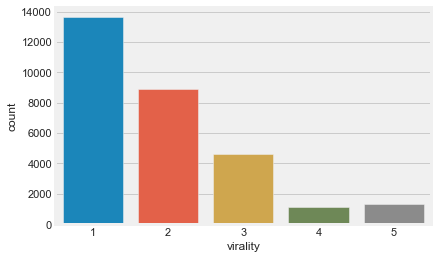

In [7]:
sns.countplot(x = 'virality', data = train_tweets);

In [8]:
train_tweets["virality"].describe()

count    29625.000000
mean         1.907274
std          1.078700
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          5.000000
Name: virality, dtype: float64

The average virality is two with the vast majority of tweets being of virality 1, this follows what we would have expected

## Virality Time Series Analysis
Looking at the virality of tweets in time 

### Virality by year

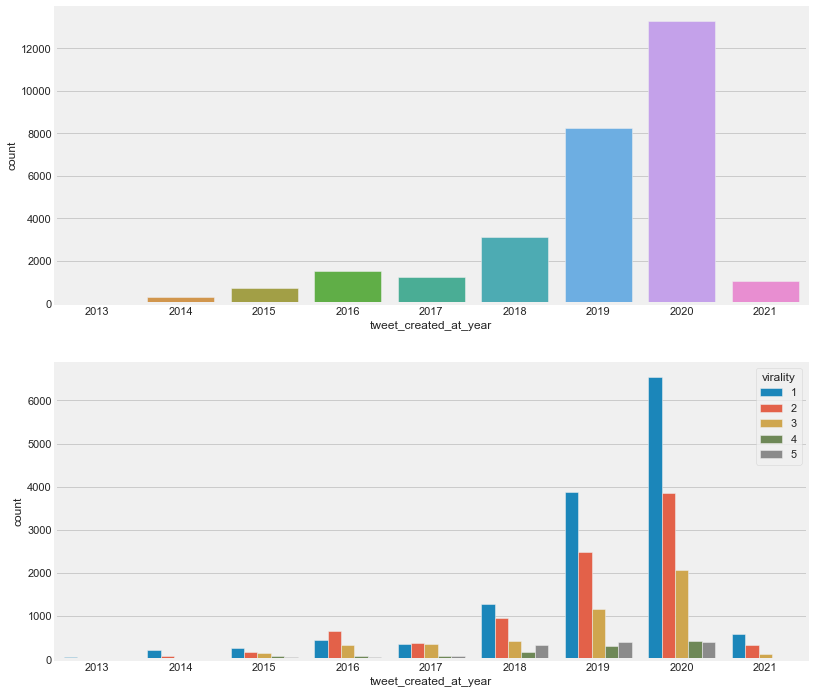

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

sns.countplot(x = 'tweet_created_at_year', data = train_tweets,ax = axs[0]);

sns.countplot(x = 'tweet_created_at_year', data = train_tweets, hue =  'virality',ax = axs[1]);

The vast majority of our data comes from 2020

### Virality by month

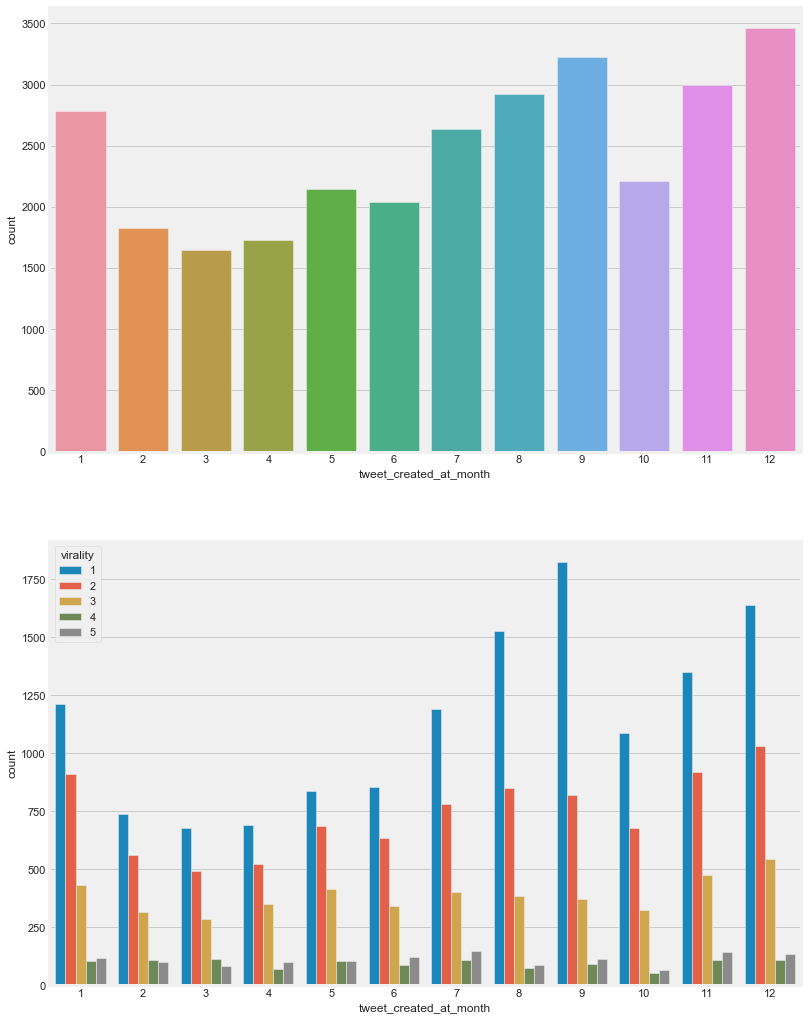

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(12, 18))

sns.countplot(x = 'tweet_created_at_month', data = train_tweets,ax = axs[0]);
sns.countplot(x = 'tweet_created_at_month', data = train_tweets, hue =  'virality',ax = axs[1]);

Most common month is December, the winter months seem to have a higher count than spring, perhaps people use twitter more in the colder winter months?

### Virality by day

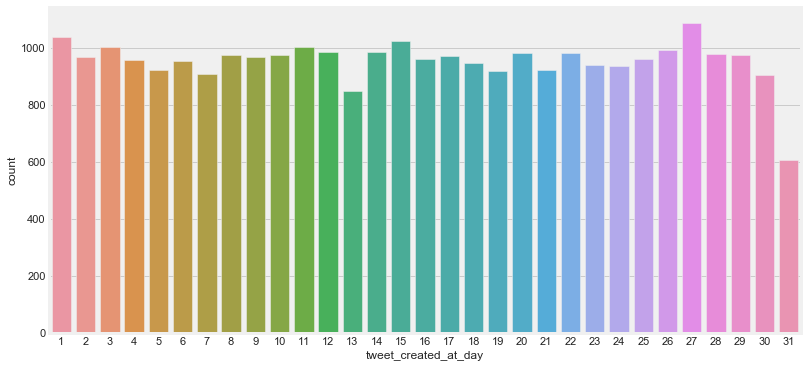

In [11]:
fig, axs = plt.subplots(1, 1, figsize=(12, 6))

sns.countplot(x = 'tweet_created_at_day', data = train_tweets);


Most common day is the 27th of the month

### Virality by hour

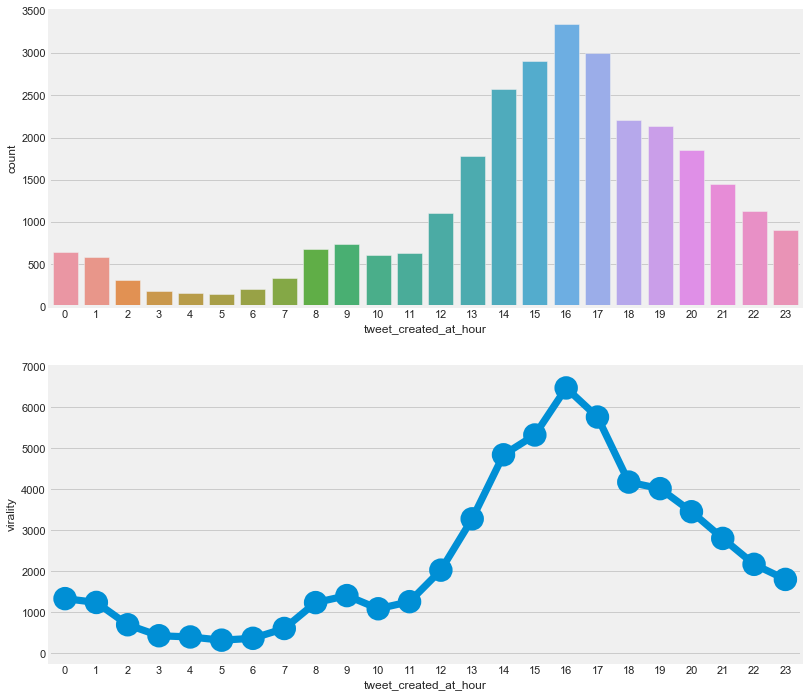

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

sns.countplot(x = 'tweet_created_at_hour', data = train_tweets,ax = axs[0]);
sns.pointplot(x = 'tweet_created_at_hour', y = 'virality', data = train_tweets, estimator = np.sum,ax = axs[1])

Most tweets were created in the evening around the end of school/workday which makes sense, and is lowest in the very early morning

### Tweet hashtag count

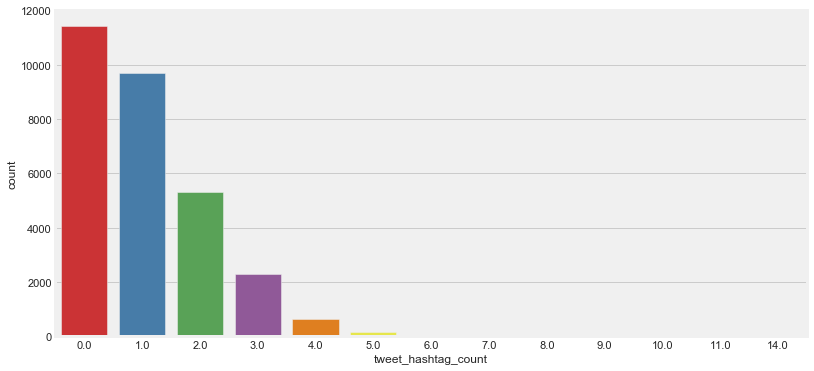

In [13]:

fig,ax=plt.subplots(1,1,figsize=(12,6))
sns.countplot(x="tweet_hashtag_count", data = train_tweets, palette = "Set1")


See that hashtags dont seem to be that popular as the vast majority of tweets have two or fewer

### Tweets by URL's

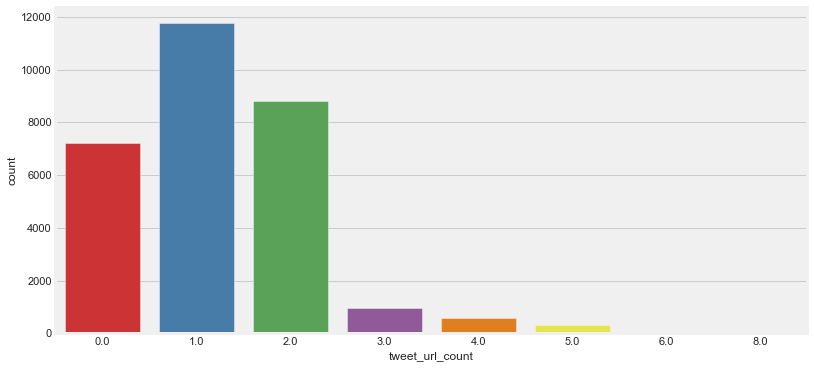

In [14]:

fig,ax=plt.subplots(1,1,figsize=(12,6))
sns.countplot(x="tweet_url_count", data = train_tweets, palette = "Set1")

Suprisingly most tweets tend to have a URL link which is not what I expected, the most common amount of urls is 1 with even 5 urls being seen enough to be noticed

### Tweets by Mentions

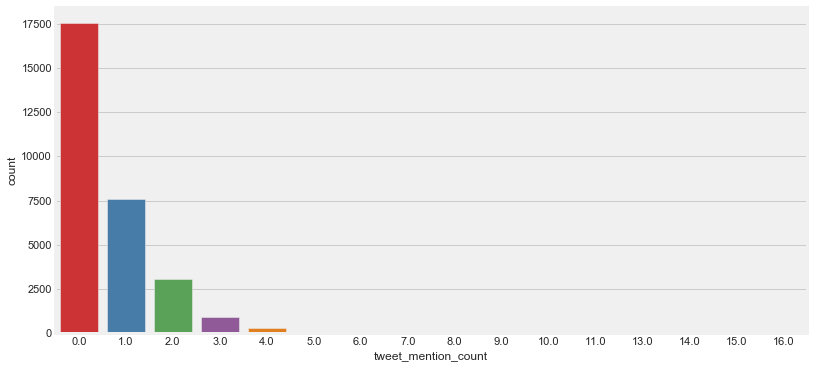

In [15]:

fig,ax=plt.subplots(1,1,figsize=(12,6))
sns.countplot(x="tweet_mention_count", data = train_tweets, palette = "Set1")

Again 0 is the most common for the number of mentions

### Tweets by Attachment Class

Text(0.5, 1.0, 'Tweets by Attachment Class')

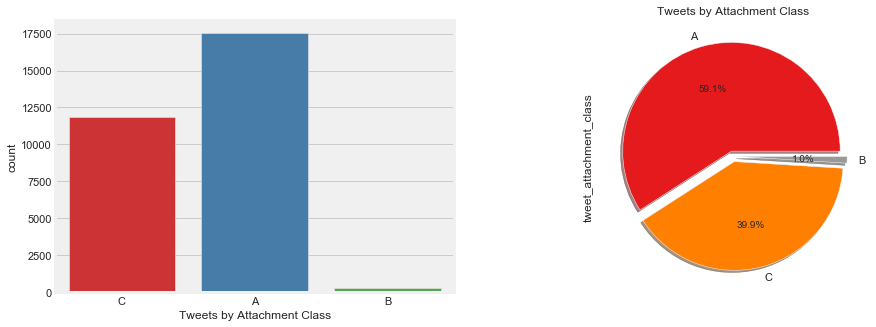

In [16]:
fig,ax=plt.subplots(1,2,figsize=(14,5))
sns.countplot(x = "tweet_attachment_class", data=train_tweets, palette = "Set1", ax = ax[0])
ax[0].set_xlabel("Tweets by Attachment Class",size=12)
train_tweets.tweet_attachment_class.value_counts().plot.pie(ax=ax[1],autopct='%1.1f%%',shadow=True,explode=[0.05,0.05,0.05], cmap = "Set1")

ax[1].set_title("Tweets by Attachment Class",size=12)

Attachment A is the most common with nearly 60% of tweets <br>
Attachment C is also very prevalent with near 40% of tweets <br>
Attachment B has a mere 1%

### Tweet by Language ID

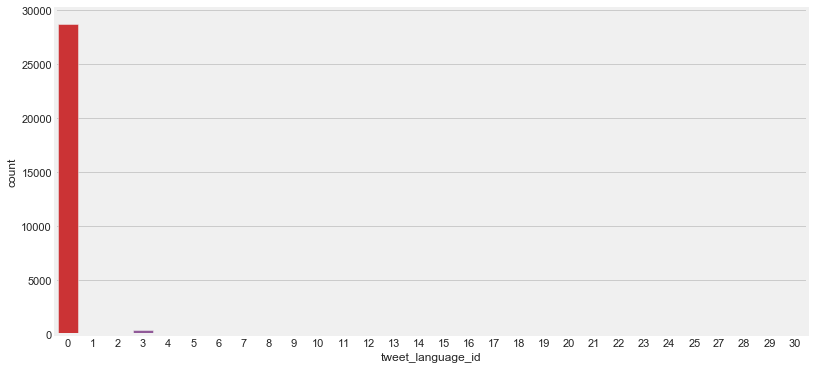

In [17]:
fig,ax=plt.subplots(1,1,figsize=(12,6))
sns.countplot(x = "tweet_language_id", data=train_tweets, palette = "Set1")


Nearly all the tweets have language id 0, this tells us that perhaps this feature might not be very useful for our prediction

### Tweets by Attachment Media

Text(0.5, 1.0, 'Tweets has attachment')

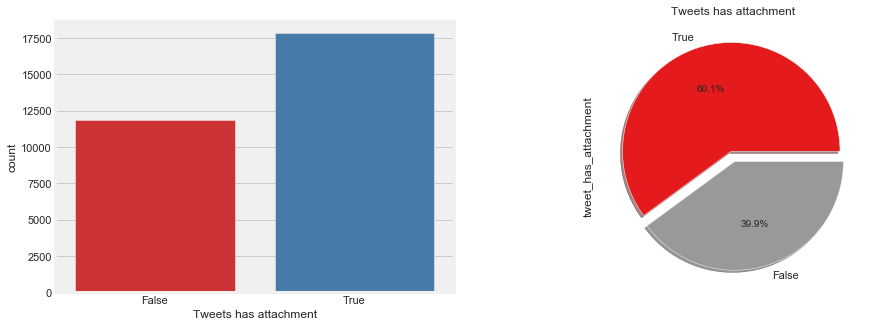

In [18]:
fig,ax=plt.subplots(1,2,figsize=(14,5))
sns.countplot(x = "tweet_has_attachment", data=train_tweets, palette = "Set1", ax = ax[0])
ax[0].set_xlabel("Tweets has attachment",size=12)
train_tweets.tweet_has_attachment.value_counts().plot.pie(ax=ax[1],autopct='%1.1f%%',shadow=True,explode=[0.05,0.05], cmap = "Set1")

ax[1].set_title("Tweets has attachment",size=12)

Majority of tweets have an attachment (perhaps memes)

## Correlation Matrix

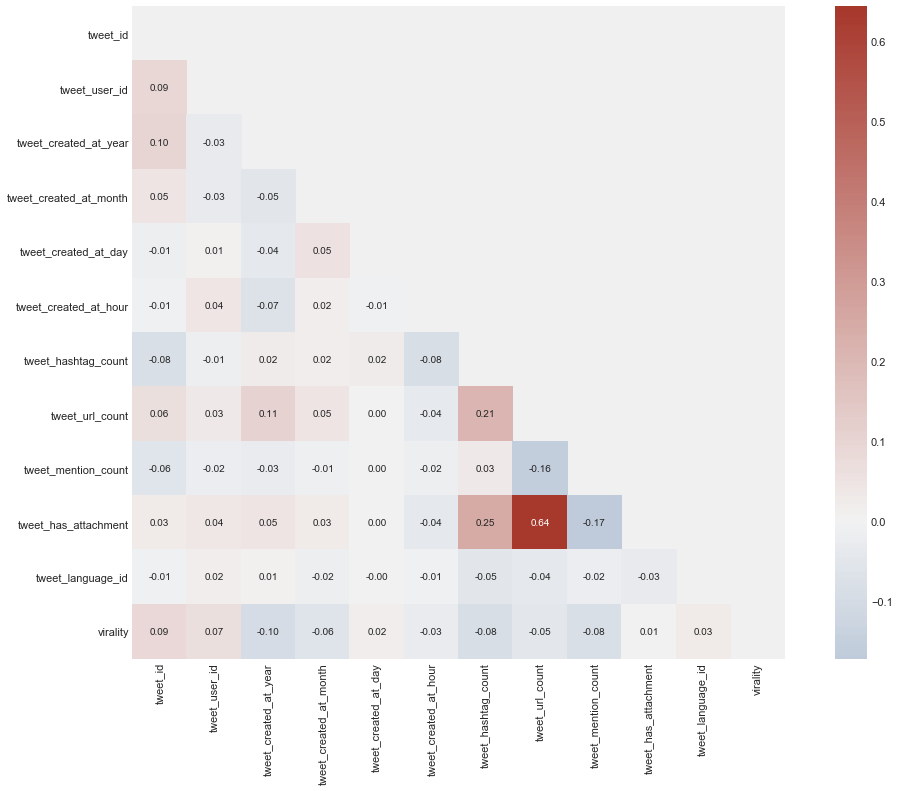

In [19]:
# Calculate pairwise-correlation
corrmat = train_tweets.corr()

# Create a mask
mask = np.triu(np.ones_like(corrmat, dtype=bool))

# Create a custom divergin palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                            n=9, center="light", as_cmap=True)

plt.figure(figsize=(16, 12))
sns.heatmap(corrmat, mask=mask, center=0, annot=True,
            fmt='.2f', square=True, cmap=cmap)


No features seem to have any relationship with virality <br>
However there seems to be an issue of multicollinearity in our data especially between tweet_has_attachment and tweet_url_count, which makes sense as if a tweet has a url therefore it must have an attachment <br>
The lack of linear relationships between the features and virality makes sense simply by how many tweets are made and how many go viral

# Analysis of User Data

In [20]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   user_id                52 non-null     int64
 1   user_like_count        52 non-null     int64
 2   user_followers_count   52 non-null     int64
 3   user_following_count   52 non-null     int64
 4   user_listed_on_count   52 non-null     int64
 5   user_has_location      52 non-null     bool 
 6   user_tweet_count       52 non-null     int64
 7   user_has_url           52 non-null     bool 
 8   user_verified          52 non-null     int64
 9   user_created_at_year   52 non-null     int64
 10  user_created_at_month  52 non-null     int64
dtypes: bool(2), int64(9)
memory usage: 3.9 KB


Majority of our 10 features are int with two bool 

In [21]:
users.head()

,user_id,user_like_count,user_followers_count,user_following_count,user_listed_on_count,user_has_location,user_tweet_count,user_has_url,user_verified,user_created_at_year,user_created_at_month
0,0,1164,48720,70469,5956,True,14122,True,0,2010,8
1,1,3914,85361,2171,5943,False,6957,False,0,2011,9
2,2,8292,200944,1416,8379,True,83485,True,0,2011,6
3,3,1770,15385,4572,1866,True,12265,True,0,2011,8
4,4,15311,459083,1021,7368,False,121193,False,0,2011,6


### User like count

<Figure size 864x576 with 0 Axes>

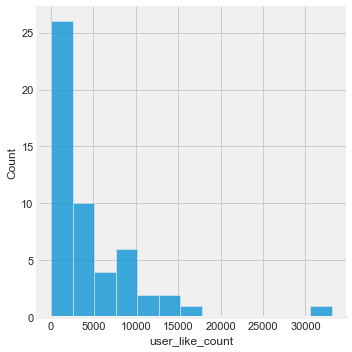

In [22]:
ax = plt.figure(figsize=(12,8))


fig = sns.displot(data=users, x = 'user_like_count');

Most users have between 0-2500 likes, the majority are below 10,000 with an outlier having more than 300,000 (yikes)

### Users follower counts 

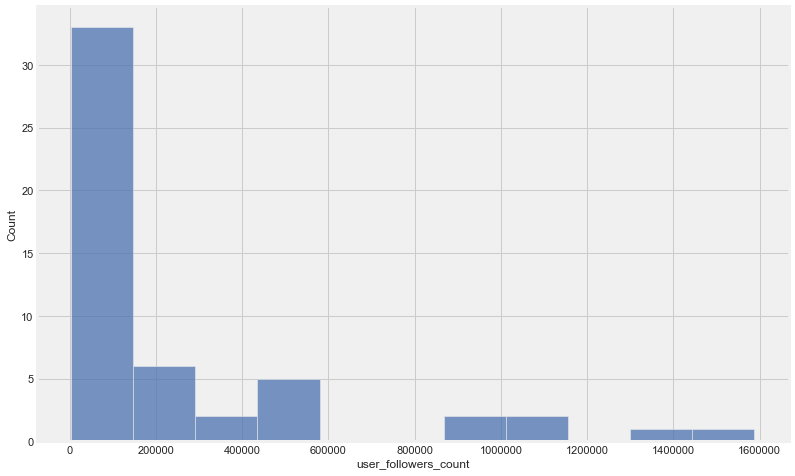

In [23]:
ax = plt.figure(figsize=(12,8))


fig = sns.histplot(users, x = 'user_followers_count');

Most of the users have below 100,000 followers which makes sense, there is a wide range of values with a user having 1.6m followers

Users following count

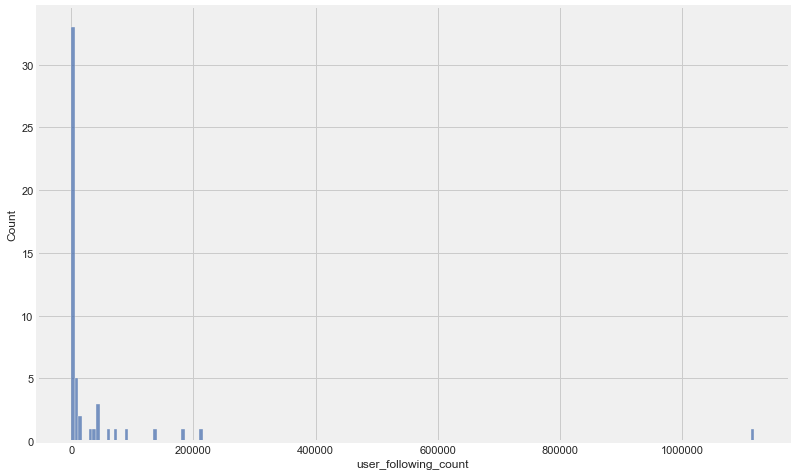

In [28]:
ax = plt.figure(figsize=(12,8))


fig = sns.histplot(users, x = 'user_following_count');

Nearly all are below 200k, however we have one large outlier who is following more than 1m 

### Users by listed on count

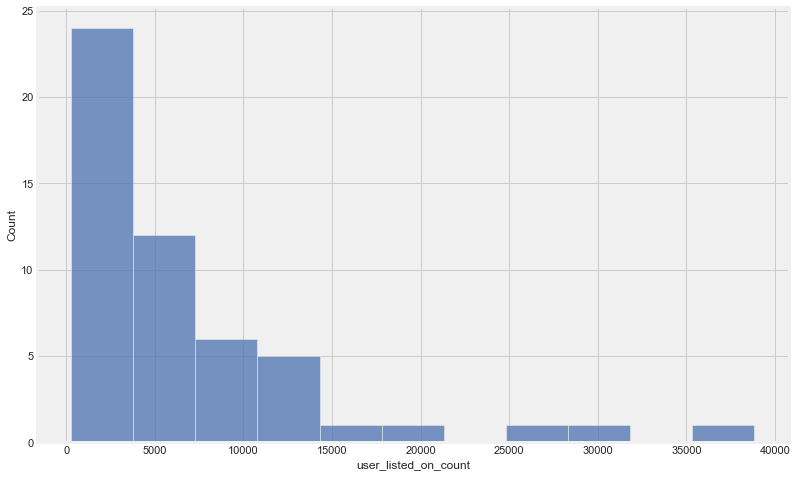

In [24]:
ax = plt.figure(figsize=(12,8))


fig = sns.histplot(users, x = 'user_listed_on_count');

Again most of them are between 0 to 5000, with some of users being listed on as many as 400k lists.

### User tweet count

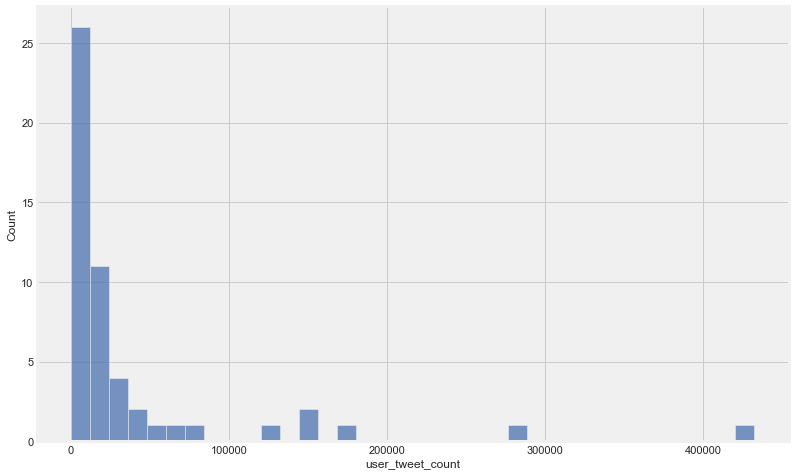

In [25]:
ax = plt.figure(figsize=(12,8))


fig = sns.histplot(users, x = 'user_tweet_count');

Large variation in number of tweets, most users are around 500k tweets which seems absurd, clearly the users in our data are very active users

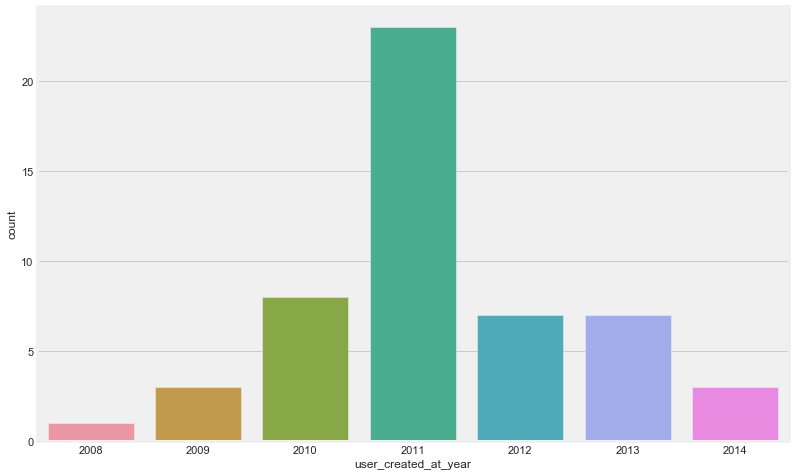

In [26]:
ax = plt.figure(figsize=(12,8))


sns.countplot(data =users, x = 'user_created_at_year')

Most users created their accounts in 2011, they are early adapters and longtime active users

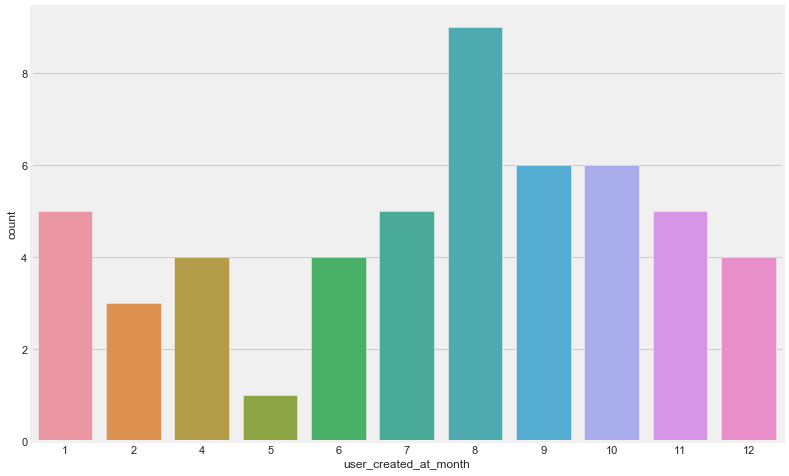

In [27]:
ax = plt.figure(figsize=(12,8))

sns.countplot(x = 'user_created_at_month', data = users);


July/August was the most common month to make an account

### User location 

Text(0.5, 1.0, 'User has location listed')

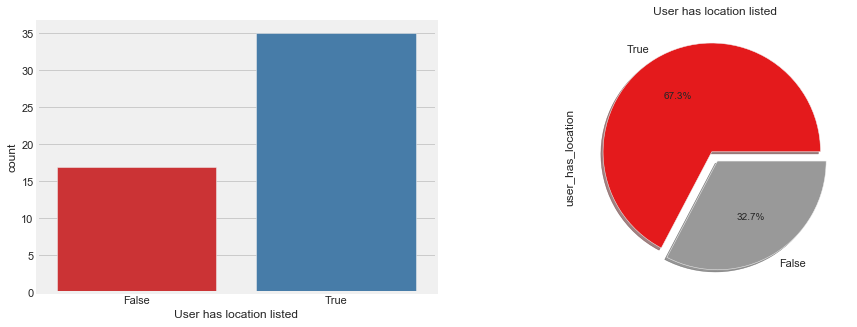

In [28]:
fig,ax=plt.subplots(1,2,figsize=(14,5))
sns.countplot(x = "user_has_location", data=users, palette = "Set1", ax = ax[0])
ax[0].set_xlabel("User has location listed",size=12)
users.user_has_location.value_counts().plot.pie(ax=ax[1],autopct='%1.1f%%',shadow=True,explode=[0.05,0.05], cmap = "Set1")

ax[1].set_title("User has location listed",size=12)

Two thirds of users have their location listed 

Text(0.5, 1.0, 'User has URL listed')

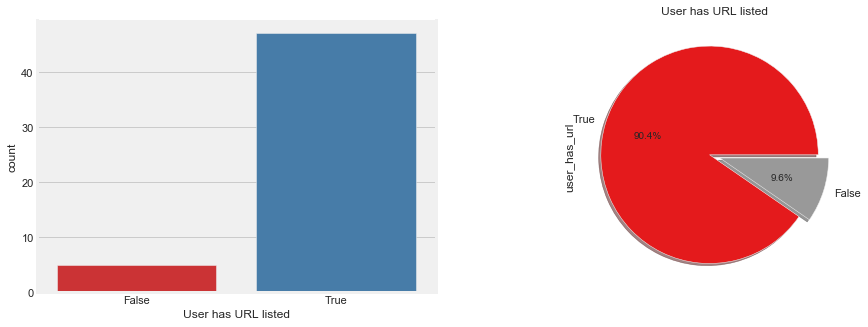

In [29]:
fig,ax=plt.subplots(1,2,figsize=(14,5))
sns.countplot(x = "user_has_url", data=users, palette = "Set1", ax = ax[0])
ax[0].set_xlabel("User has URL listed",size=12)
users.user_has_url.value_counts().plot.pie(ax=ax[1],autopct='%1.1f%%',shadow=True,explode=[0.05,0.05], cmap = "Set1")

ax[1].set_title("User has URL listed",size=12)

90% of users have a URL listed

Text(0.5, 1.0, 'User is verified')

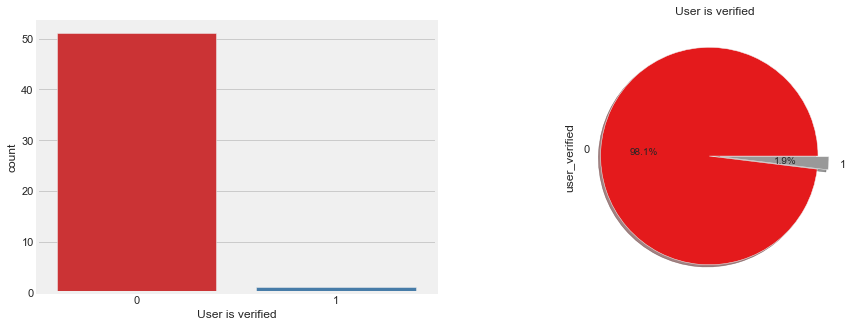

In [30]:
fig,ax=plt.subplots(1,2,figsize=(14,5))
sns.countplot(x = "user_verified", data=users, palette = "Set1", ax = ax[0])
ax[0].set_xlabel("User is verified",size=12)
users.user_verified.value_counts().plot.pie(ax=ax[1],autopct='%1.1f%%',shadow=True,explode=[0.05,0.05], cmap = "Set1")

ax[1].set_title("User is verified",size=12)

Nearly all our users are unverified

# Data Preprocessing

### Data Types

In [36]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   user_id                52 non-null     int64
 1   user_like_count        52 non-null     int64
 2   user_followers_count   52 non-null     int64
 3   user_following_count   52 non-null     int64
 4   user_listed_on_count   52 non-null     int64
 5   user_has_location      52 non-null     bool 
 6   user_tweet_count       52 non-null     int64
 7   user_has_url           52 non-null     bool 
 8   user_verified          52 non-null     int64
 9   user_created_at_year   52 non-null     int64
 10  user_created_at_month  52 non-null     int64
dtypes: bool(2), int64(9)
memory usage: 3.9 KB


In [37]:
users.head()

,user_id,user_like_count,user_followers_count,user_following_count,user_listed_on_count,user_has_location,user_tweet_count,user_has_url,user_verified,user_created_at_year,user_created_at_month
0,0,1164,48720,70469,5956,True,14122,True,0,2010,8
1,1,3914,85361,2171,5943,False,6957,False,0,2011,9
2,2,8292,200944,1416,8379,True,83485,True,0,2011,6
3,3,1770,15385,4572,1866,True,12265,True,0,2011,8
4,4,15311,459083,1021,7368,False,121193,False,0,2011,6


All the features seem to be the right data type, perhaps user verified could be changed to bool but bool or binary they will both be changed when we incorperate our dummy variables anyway so its fine

In [38]:
train_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29625 entries, 0 to 29624
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   tweet_id                29625 non-null  int64  
 1   tweet_user_id           29625 non-null  int64  
 2   tweet_created_at_year   29625 non-null  int64  
 3   tweet_created_at_month  29625 non-null  int64  
 4   tweet_created_at_day    29625 non-null  int64  
 5   tweet_created_at_hour   29625 non-null  int64  
 6   tweet_hashtag_count     29625 non-null  float64
 7   tweet_url_count         29625 non-null  float64
 8   tweet_mention_count     29625 non-null  float64
 9   tweet_has_attachment    29625 non-null  bool   
 10  tweet_attachment_class  29625 non-null  object 
 11  tweet_language_id       29625 non-null  int64  
 12  tweet_topic_ids         25340 non-null  object 
 13  virality                29625 non-null  int64  
dtypes: bool(1), float64(3), int64(8), obje

In [39]:
train_tweets.head(5)

,tweet_id,tweet_user_id,tweet_created_at_year,tweet_created_at_month,tweet_created_at_day,tweet_created_at_hour,tweet_hashtag_count,tweet_url_count,tweet_mention_count,tweet_has_attachment,tweet_attachment_class,tweet_language_id,tweet_topic_ids,virality
0,34698,10,2015,12,5,3,2.0,1.0,0.0,False,C,0,"['36', '36', '36', '36', '36', '36', '37', '37...",3
1,24644,4,2020,6,19,0,0.0,1.0,0.0,False,C,0,"['43', '78', '79', '80', '80', '89', '98', '99...",3
2,36321,54,2019,6,2,15,2.0,3.0,0.0,True,A,0,"['79', '80', '98', '98', '98', '99', '99', '10...",1
3,2629,42,2020,9,6,17,0.0,1.0,1.0,True,A,0,"['43', '79', '80', '98', '99', '99', '79', '80']",2
4,28169,32,2020,11,4,17,2.0,1.0,0.0,True,A,0,"['79', '80', '98', '99', '43', '89']",2


We have a few float types that should be int as they all end in .0 so we will transform them to int64 type

In [40]:
cols = ['tweet_hashtag_count', 'tweet_url_count', 'tweet_mention_count']
train_tweets[cols] = train_tweets[cols].applymap(np.int64)
train_tweets[cols].head()

,tweet_hashtag_count,tweet_url_count,tweet_mention_count
0,2,1,0
1,0,1,0
2,2,3,0
3,0,1,1
4,2,1,0


### Imputing Missing values

In [31]:
def missing_values(df):
    if df.isnull().values.any()==False:
        return False
    all_data_na = (df.isnull().sum() / len(df)) * 100

    all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]

    missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
    return missing_data.head(len(df.columns))

missing_values(users)

False

In [38]:
missing_values(train_tweets)

,Missing Ratio
tweet_topic_ids,14.464135


Our user data has no missing values, while the only column in our train_tweets with missing data is tweet_topic_ids <br>
For tweet_topic_ids we cant assume a topic so we will set it that we have no topic, as we have arrays with integers for this column and we will need to fix that also its easier to set the NaN rows to an array also 

In [39]:
train_tweets.fillna({'tweet_topic_ids':"['0']"}, inplace=True)
missing_values(train_tweets)

False

### Dealing with array feature

In [40]:
topic_ids = (
    train_tweets['tweet_topic_ids'].str.strip('[]').str.split('\s*,\s*').explode()
    .str.get_dummies().sum(level=0).add_prefix('topic_id_')
) 
topic_ids.rename(columns = lambda x: x.replace("'", ""), inplace=True)

### Fix Outliers

In [41]:
def outliers(x):
    ##Get all the column name from the input dataframe x
    xColumnNames=users.columns
    print(xColumnNames)
    #for j in df2ColumnNames:

    for j in xColumnNames:
        try:
    
            xy=x[j]    
            mydata=pd.DataFrame()
            #print(xy)
            updated=[]
            Q1,Q3=np.percentile(xy,[25,75])
            IQR=Q3-Q1
            minimum=Q1-1.5*IQR
            maximum=Q3+1.5*IQR
            for i in xy:
                if(i>maximum):
                    print("Entering maxim")
                    i=maximum
                    updated.append(i)
                elif(i<minimum):
                    print("entering minimum")
                    i=minimum
                    updated.append(i)
                else:
                    updated.append(i)
            x[j]=updated
        except:
            continue
    return x
outliers(users)

Index(['user_id', 'user_like_count', 'user_followers_count',
       'user_following_count', 'user_listed_on_count', 'user_has_location',
       'user_tweet_count', 'user_has_url', 'user_verified',
       'user_created_at_year', 'user_created_at_month'],
      dtype='object')
Entering maxim
Entering maxim
Entering maxim
Entering maxim
Entering maxim
Entering maxim
Entering maxim
Entering maxim
Entering maxim
Entering maxim
Entering maxim
Entering maxim
Entering maxim
Entering maxim
Entering maxim
Entering maxim
Entering maxim
Entering maxim
Entering maxim
Entering maxim
Entering maxim
Entering maxim
Entering maxim
Entering maxim
Entering maxim
Entering maxim
Entering maxim
Entering maxim
Entering maxim
Entering maxim
Entering maxim
Entering maxim
Entering maxim
Entering maxim
Entering maxim
entering minimum
entering minimum
entering minimum
Entering maxim
entering minimum
Entering maxim


,user_id,user_like_count,user_followers_count,user_following_count,user_listed_on_count,user_has_location,user_tweet_count,user_has_url,user_verified,user_created_at_year,user_created_at_month
0,0,1164.000,48720.000,28285.125,5956.000,True,14122.000,True,0.0,2010.0,8
1,1,3914.000,85361.000,2171.000,5943.000,False,6957.000,False,0.0,2011.0,9
2,2,8292.000,200944.000,1416.000,8379.000,True,63106.375,True,0.0,2011.0,6
3,3,1770.000,15385.000,4572.000,1866.000,True,12265.000,True,0.0,2011.0,8
4,4,14055.375,459083.000,1021.000,7368.000,False,63106.375,False,0.0,2011.0,6
5,5,882.000,5969.000,2352.000,841.000,True,3184.000,False,0.0,2011.0,1
6,6,4736.000,23127.000,1345.000,909.000,False,12033.000,True,0.0,2011.0,1
7,7,0.000,103254.000,529.000,990.000,True,169.000,True,0.0,2013.5,11
8,8,7776.000,168167.000,11290.000,1816.000,True,7065.000,True,0.0,2013.0,4
9,10,9365.000,398591.000,28285.125,18462.000,True,63106.375,True,0.0,2011.0,10


In [46]:
outliers(train_tweets)

Index(['user_id', 'user_like_count', 'user_followers_count',
       'user_following_count', 'user_listed_on_count', 'user_has_location',
       'user_tweet_count', 'user_has_url', 'user_verified',
       'user_created_at_year', 'user_created_at_month'],
      dtype='object')


,tweet_id,tweet_user_id,tweet_created_at_year,tweet_created_at_month,tweet_created_at_day,tweet_created_at_hour,tweet_hashtag_count,tweet_url_count,tweet_mention_count,tweet_has_attachment,tweet_attachment_class,tweet_language_id,tweet_topic_ids,virality
0,34698,10,2015,12,5,3,2,1,0,False,C,0,"['36', '36', '36', '36', '36', '36', '37', '37...",3
1,24644,4,2020,6,19,0,0,1,0,False,C,0,"['43', '78', '79', '80', '80', '89', '98', '99...",3
2,36321,54,2019,6,2,15,2,3,0,True,A,0,"['79', '80', '98', '98', '98', '99', '99', '10...",1
3,2629,42,2020,9,6,17,0,1,1,True,A,0,"['43', '79', '80', '98', '99', '99', '79', '80']",2
4,28169,32,2020,11,4,17,2,1,0,True,A,0,"['79', '80', '98', '99', '43', '89']",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29620,24846,4,2019,8,30,17,0,1,0,True,A,0,"['78', '79', '80', '98', '99', '100', '78', '7...",3
29621,7320,21,2018,12,21,13,2,1,0,True,A,0,"['98', '99', '100']",2
29622,7447,21,2018,9,29,18,0,1,0,True,A,0,"['98', '99', '100']",2
29623,26737,41,2017,2,5,16,0,2,0,True,A,0,['0'],2


### One hot encoding

In [42]:
year = pd.get_dummies(train_tweets.tweet_created_at_year, prefix='year')
month = pd.get_dummies(train_tweets.tweet_created_at_month , prefix='month')
day = pd.get_dummies(train_tweets.tweet_created_at_day, prefix='day')
attachment = pd.get_dummies(train_tweets.tweet_attachment_class, prefix='attatchment')
language = pd.get_dummies(train_tweets.tweet_language_id, prefix='language')

In [43]:

sin_hour = np.sin(2*np.pi*train_tweets['tweet_created_at_hour']/23.0)
sin_hour.name = 'sin_hour'
cos_hour = np.cos(2*np.pi*train_tweets['tweet_created_at_hour']/23.0)
cos_hour.name = 'cos_hour'

In [44]:
columns_drop = [
                "tweet_topic_ids",
                "tweet_created_at_year",
                "tweet_created_at_month",
                "tweet_created_at_day",
                "tweet_attachment_class",
                "tweet_language_id",
                "tweet_created_at_hour",
               ]
    

dfs = [topic_ids, year, month, day, attachment, language, 
       sin_hour, cos_hour]


train_tweets_final= train_tweets.drop(columns_drop, 1).join(dfs)

train_tweets_final.head()

,tweet_id,tweet_user_id,tweet_hashtag_count,tweet_url_count,tweet_mention_count,tweet_has_attachment,virality,topic_id_0,topic_id_100,topic_id_101,...,language_22,language_23,language_24,language_25,language_27,language_28,language_29,language_30,sin_hour,cos_hour
0,34698,10,2.0,1.0,0.0,False,3,0,0,0,...,0,0,0,0,0,0,0,0,0.730836,0.682553
1,24644,4,0.0,1.0,0.0,False,3,0,1,0,...,0,0,0,0,0,0,0,0,0.000000,1.000000
2,36321,54,2.0,3.0,0.0,True,1,0,2,0,...,0,0,0,0,0,0,0,0,-0.816970,-0.576680
3,2629,42,0.0,1.0,1.0,True,2,0,0,0,...,0,0,0,0,0,0,0,0,-0.997669,-0.068242
4,28169,32,2.0,1.0,0.0,True,2,0,0,0,...,0,0,0,0,0,0,0,0,-0.997669,-0.068242


Using Cycical Encoding as its time series and repeats 

In [45]:
year = pd.get_dummies(users.user_created_at_year, prefix='year')
month = pd.get_dummies(users.user_created_at_month , prefix='month')
user_verified = pd.get_dummies(users.user_verified, prefix='verified')

columns_drop = [
                "user_created_at_year",
                "user_created_at_month",
                "user_verified"
              ]

dfs = [
        year,
        month,
        user_verified
      ]


users_final = users.drop(columns_drop, 1).join(dfs)
users_final.head()


,user_id,user_like_count,user_followers_count,user_following_count,user_listed_on_count,user_has_location,user_tweet_count,user_has_url,year_2009.5,year_2010.0,...,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,verified_0.0
0,0,1164.000,48720.0,28285.125,5956.0,True,14122.000,True,0,1,...,0,0,0,0,1,0,0,0,0,1
1,1,3914.000,85361.0,2171.000,5943.0,False,6957.000,False,0,0,...,0,0,0,0,0,1,0,0,0,1
2,2,8292.000,200944.0,1416.000,8379.0,True,63106.375,True,0,0,...,0,0,1,0,0,0,0,0,0,1
3,3,1770.000,15385.0,4572.000,1866.0,True,12265.000,True,0,0,...,0,0,0,0,1,0,0,0,0,1
4,4,14055.375,459083.0,1021.000,7368.0,False,63106.375,False,0,0,...,0,0,1,0,0,0,0,0,0,1


### Lasso Regression for Feature Selection 

In [46]:
train_tweets.head()

,tweet_id,tweet_user_id,tweet_created_at_year,tweet_created_at_month,tweet_created_at_day,tweet_created_at_hour,tweet_hashtag_count,tweet_url_count,tweet_mention_count,tweet_has_attachment,tweet_attachment_class,tweet_language_id,tweet_topic_ids,virality
0,34698,10,2015,12,5,3,2.0,1.0,0.0,False,C,0,"['36', '36', '36', '36', '36', '36', '37', '37...",3
1,24644,4,2020,6,19,0,0.0,1.0,0.0,False,C,0,"['43', '78', '79', '80', '80', '89', '98', '99...",3
2,36321,54,2019,6,2,15,2.0,3.0,0.0,True,A,0,"['79', '80', '98', '98', '98', '99', '99', '10...",1
3,2629,42,2020,9,6,17,0.0,1.0,1.0,True,A,0,"['43', '79', '80', '98', '99', '99', '79', '80']",2
4,28169,32,2020,11,4,17,2.0,1.0,0.0,True,A,0,"['79', '80', '98', '99', '43', '89']",2


In [47]:
vectorized_media_df = pd.merge(train_tweets,train_tweets_vectorized_media, on ='tweet_id', how = 'right')
vectorized_media_df.drop(train_tweets.columns.difference(['virality']), axis=1, inplace=True)
vectorized_media_df.head()

,virality,media_id,img_feature_0,img_feature_1,img_feature_2,img_feature_3,img_feature_4,img_feature_5,img_feature_6,img_feature_7,...,img_feature_2038,img_feature_2039,img_feature_2040,img_feature_2041,img_feature_2042,img_feature_2043,img_feature_2044,img_feature_2045,img_feature_2046,img_feature_2047
0,1,00001_00000,0.290614,0.150803,0.008313,0.040887,0.0,0.000000,0.214209,0.000792,...,0.000000,0.249240,0.040368,0.101314,0.000000,0.069272,0.167507,0.044617,0.383093,0.097627
1,2,00004_00003,0.038251,0.036437,0.000000,0.015076,0.0,0.046953,0.648170,0.026476,...,0.024564,0.035555,0.369353,0.000000,0.133307,0.000000,0.000000,0.017894,0.816972,0.058774
2,1,00005_00004,0.506981,0.305467,0.036150,0.114539,0.0,0.146888,0.584753,0.157468,...,0.000000,0.131493,0.268107,0.000000,0.036761,0.008600,0.018883,0.024825,0.123289,0.000000
3,1,00008_00007,0.000000,0.242857,0.000000,0.068217,0.0,0.117847,0.000000,0.000000,...,0.095629,0.221957,0.133745,0.023491,0.000000,0.000000,0.000000,0.065544,1.030737,0.010370
4,1,00009_00008,0.000000,0.141986,0.000000,0.000983,0.0,0.013148,0.066999,0.008579,...,0.000000,0.480097,0.361314,0.026121,0.000000,0.000000,0.000000,0.001085,0.653569,0.007591


In [48]:
y = vectorized_media_df['virality']
x = vectorized_media_df.loc[:, vectorized_media_df.columns.str.contains("img_")] 

In [49]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

C:\Users\johnl\Anaconda\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\johnl\Anaconda\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, e

In [50]:
selector = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear')).fit(x, y)


In [51]:
selector.threshold_

1e-05

In [52]:
selector.get_support()
sel_index = selector.get_support()

In [53]:
counter = collections.Counter(selector.get_support())
counter

Counter({True: 2047, False: 1})

In [54]:
media_ind_df = pd.DataFrame(x[x.columns[(sel_index)]])
train_tweets_media_final = pd.concat([train_tweets_vectorized_media[['media_id', 'tweet_id']], media_ind_df], axis=1)
train_tweets_media_final.head()

,media_id,tweet_id,img_feature_0,img_feature_1,img_feature_2,img_feature_3,img_feature_4,img_feature_5,img_feature_6,img_feature_7,...,img_feature_2038,img_feature_2039,img_feature_2040,img_feature_2041,img_feature_2042,img_feature_2043,img_feature_2044,img_feature_2045,img_feature_2046,img_feature_2047
0,00001_00000,1,0.290614,0.150803,0.008313,0.040887,0.0,0.000000,0.214209,0.000792,...,0.000000,0.249240,0.040368,0.101314,0.000000,0.069272,0.167507,0.044617,0.383093,0.097627
1,00004_00003,4,0.038251,0.036437,0.000000,0.015076,0.0,0.046953,0.648170,0.026476,...,0.024564,0.035555,0.369353,0.000000,0.133307,0.000000,0.000000,0.017894,0.816972,0.058774
2,00005_00004,5,0.506981,0.305467,0.036150,0.114539,0.0,0.146888,0.584753,0.157468,...,0.000000,0.131493,0.268107,0.000000,0.036761,0.008600,0.018883,0.024825,0.123289,0.000000
3,00008_00007,8,0.000000,0.242857,0.000000,0.068217,0.0,0.117847,0.000000,0.000000,...,0.095629,0.221957,0.133745,0.023491,0.000000,0.000000,0.000000,0.065544,1.030737,0.010370
4,00009_00008,9,0.000000,0.141986,0.000000,0.000983,0.0,0.013148,0.066999,0.008579,...,0.000000,0.480097,0.361314,0.026121,0.000000,0.000000,0.000000,0.001085,0.653569,0.007591


In [55]:
vectorized_text_df = pd.merge(train_tweets,train_tweets_vectorized_text, on ='tweet_id', how = 'right')
vectorized_text_df.drop(train_tweets.columns.difference(['virality']), axis=1, inplace=True)
vectorized_text_df.head()

,virality,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_758,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767
0,1,0.125605,-0.136067,-0.121691,-0.160296,-0.074407,0.119014,-0.343523,-0.289790,-0.037007,...,0.215511,-0.330016,-0.143669,-0.017097,0.211852,0.009358,0.205395,-0.100113,0.013015,0.053247
1,1,0.064982,-0.116850,0.034871,-0.090357,-0.067459,0.030954,-0.361263,-0.294617,-0.077854,...,0.193301,-0.391395,-0.120417,-0.072493,0.188275,-0.084694,0.152518,-0.109684,0.034304,0.018237
2,2,0.051160,-0.076732,0.005174,-0.071699,-0.204004,0.034764,-0.320014,-0.231828,-0.121784,...,0.163904,-0.299526,-0.099811,-0.049208,0.170104,-0.125188,0.111381,-0.180564,-0.061082,0.142650
3,1,0.127061,-0.063152,0.010520,0.000385,-0.146983,-0.099981,-0.382142,-0.287832,-0.129653,...,0.168049,-0.355778,-0.150411,-0.067176,0.216000,-0.076183,0.158889,-0.057773,-0.079182,0.057414
4,1,0.144889,-0.084671,0.147057,-0.068760,-0.024226,0.081921,-0.362943,-0.288691,-0.121206,...,0.212959,-0.389882,-0.157168,-0.051536,0.129986,-0.021489,0.184418,-0.058603,-0.023088,0.084837


In [56]:
y = vectorized_text_df['virality']
x = vectorized_text_df.loc[:, vectorized_text_df.columns.str.contains("feature_")] 

In [57]:
selector = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear')).fit(x, y)

In [58]:
selector.threshold_

1e-05

In [59]:
selector.get_support()
sel_index = selector.get_support()

In [60]:
counter = collections.Counter(selector.get_support())
counter

Counter({True: 675, False: 93})

In [61]:
train_tweets_vectorized_text.head()

,tweet_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_758,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767
0,0,0.125605,-0.136067,-0.121691,-0.160296,-0.074407,0.119014,-0.343523,-0.289790,-0.037007,...,0.215511,-0.330016,-0.143669,-0.017097,0.211852,0.009358,0.205395,-0.100113,0.013015,0.053247
1,1,0.064982,-0.116850,0.034871,-0.090357,-0.067459,0.030954,-0.361263,-0.294617,-0.077854,...,0.193301,-0.391395,-0.120417,-0.072493,0.188275,-0.084694,0.152518,-0.109684,0.034304,0.018237
2,4,0.051160,-0.076732,0.005174,-0.071699,-0.204004,0.034764,-0.320014,-0.231828,-0.121784,...,0.163904,-0.299526,-0.099811,-0.049208,0.170104,-0.125188,0.111381,-0.180564,-0.061082,0.142650
3,5,0.127061,-0.063152,0.010520,0.000385,-0.146983,-0.099981,-0.382142,-0.287832,-0.129653,...,0.168049,-0.355778,-0.150411,-0.067176,0.216000,-0.076183,0.158889,-0.057773,-0.079182,0.057414
4,8,0.144889,-0.084671,0.147057,-0.068760,-0.024226,0.081921,-0.362943,-0.288691,-0.121206,...,0.212959,-0.389882,-0.157168,-0.051536,0.129986,-0.021489,0.184418,-0.058603,-0.023088,0.084837


In [62]:
text_ind_df = pd.DataFrame(x[x.columns[(sel_index)]])
train_tweets_text_final = pd.concat([train_tweets_vectorized_text[['tweet_id']], text_ind_df], axis=1)
train_tweets_text_final.head()

,tweet_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_757,feature_758,feature_759,feature_760,feature_761,feature_763,feature_764,feature_765,feature_766,feature_767
0,0,0.125605,-0.136067,-0.121691,-0.160296,-0.074407,0.119014,-0.343523,-0.289790,-0.037007,...,-0.090837,0.215511,-0.330016,-0.143669,-0.017097,0.009358,0.205395,-0.100113,0.013015,0.053247
1,1,0.064982,-0.116850,0.034871,-0.090357,-0.067459,0.030954,-0.361263,-0.294617,-0.077854,...,-0.025049,0.193301,-0.391395,-0.120417,-0.072493,-0.084694,0.152518,-0.109684,0.034304,0.018237
2,4,0.051160,-0.076732,0.005174,-0.071699,-0.204004,0.034764,-0.320014,-0.231828,-0.121784,...,-0.049114,0.163904,-0.299526,-0.099811,-0.049208,-0.125188,0.111381,-0.180564,-0.061082,0.142650
3,5,0.127061,-0.063152,0.010520,0.000385,-0.146983,-0.099981,-0.382142,-0.287832,-0.129653,...,-0.036280,0.168049,-0.355778,-0.150411,-0.067176,-0.076183,0.158889,-0.057773,-0.079182,0.057414
4,8,0.144889,-0.084671,0.147057,-0.068760,-0.024226,0.081921,-0.362943,-0.288691,-0.121206,...,-0.054657,0.212959,-0.389882,-0.157168,-0.051536,-0.021489,0.184418,-0.058603,-0.023088,0.084837


### Feature Selection User data

we need to add our target (virality) to this df, each user has several tweets so we need to decide how we want to determine a virality for a user.  <br> 
#### Options<br>
The 3 obvious options are Mean, Median and Mode <br>
**Mean** Probably not a good idea, someone could have one tweet that goes very viral and the rest are the lowest level of virality (which is practice is often the case) so should avoid <br>
**Mode** As we have the virality level as different catagories this could be effective <br>
**Median** Safe bet that is usually the most effective, as virality will be skewed in nature this is probably our best bet <br>

So we can get the median of each users virality and append it to our users dataframe

In [63]:
viral_avg = (train_tweets.groupby('tweet_user_id').agg(pd.Series.median)['virality'])
print(viral_avg)

tweet_user_id
0     1
1     2
2     1
3     1
4     3
5     1
6     1
7     3
8     1
10    3
11    2
12    3
13    1
14    1
15    1
16    1
17    1
18    1
19    1
20    1
21    2
22    2
23    1
24    2
25    1
26    1
27    2
28    3
30    3
31    2
32    3
33    3
34    1
35    3
37    1
38    3
39    1
40    3
41    2
42    2
43    1
44    1
45    1
46    2
47    2
48    1
49    2
50    5
52    1
53    1
54    2
55    1
Name: virality, dtype: int64


In [64]:
user_descriptions_df = pd.merge(viral_avg, user_vectorized_descriptions, left_on ='tweet_user_id', right_on = 'user_id', how = 'right')
user_profile_images_df = pd.merge(viral_avg, user_vectorized_profile_images, left_on ='tweet_user_id', right_on = 'user_id', how = 'right')
user_descriptions_df.head()

,virality,user_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_758,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767
0,1,0,0.132536,-0.137393,-0.064037,-0.118342,-0.130279,0.048067,-0.421301,-0.313038,...,0.238264,-0.315408,-0.159851,-0.003840,0.213492,0.002498,0.177574,-0.136515,-0.012882,0.017399
1,2,1,0.107849,-0.168418,0.027251,-0.075079,-0.084762,0.076149,-0.390708,-0.271934,...,0.232922,-0.314534,-0.177011,-0.041710,0.209785,-0.023427,0.158203,-0.143221,0.030484,0.081693
2,1,2,0.122312,-0.159376,-0.073417,-0.149442,-0.122684,-0.005277,-0.351233,-0.297342,...,0.173621,-0.292476,-0.185078,-0.026784,0.184902,0.009539,0.217004,-0.091951,0.025304,0.058501
3,1,3,0.160509,-0.137915,-0.002524,-0.034696,0.028126,0.056299,-0.365196,-0.259523,...,0.205752,-0.300688,-0.133753,0.002206,0.245214,-0.056659,0.152064,-0.180211,0.022327,0.014688
4,3,4,0.099192,-0.140809,-0.012423,-0.150097,-0.120169,0.054078,-0.384291,-0.269650,...,0.179307,-0.367725,-0.217667,-0.064391,0.163382,-0.020638,0.181554,-0.200262,-0.074513,0.037301


In [65]:
y = user_descriptions_df['virality']
x = user_descriptions_df.loc[:, user_descriptions_df.columns.str.contains("feature_")] 

In [66]:
selector = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear')).fit(x, y)

In [67]:
selector.get_support()
sel_index = selector.get_support()

In [68]:
counter = collections.Counter(selector.get_support())
counter

Counter({False: 768})

In [69]:
desc_ind_df = pd.DataFrame(x[x.columns[(sel_index)]])
user_descriptions_final = pd.concat([user_vectorized_descriptions[['user_id']], desc_ind_df], axis=1)
user_descriptions_final.head()

,user_id
0,0
1,1
2,2
3,3
4,4


In [70]:
media_df =train_tweets_media_final.groupby('tweet_id').mean()
media_df

,img_feature_0,img_feature_1,img_feature_2,img_feature_3,img_feature_4,img_feature_5,img_feature_6,img_feature_7,img_feature_8,img_feature_9,...,img_feature_2038,img_feature_2039,img_feature_2040,img_feature_2041,img_feature_2042,img_feature_2043,img_feature_2044,img_feature_2045,img_feature_2046,img_feature_2047
tweet_id,,,,,,,,,,,,,,,,,,,,,
1,0.290614,0.150803,0.008313,0.040887,0.000000,0.000000,0.214209,0.000792,0.000270,0.424207,...,0.000000,0.249240,0.040368,0.101314,0.000000,0.069272,0.167507,0.044617,0.383093,0.097627
4,0.038251,0.036437,0.000000,0.015076,0.000000,0.046953,0.648170,0.026476,0.000000,0.191951,...,0.024564,0.035555,0.369353,0.000000,0.133307,0.000000,0.000000,0.017894,0.816972,0.058774
5,0.506981,0.305467,0.036150,0.114539,0.000000,0.146888,0.584753,0.157468,0.000000,0.040884,...,0.000000,0.131493,0.268107,0.000000,0.036761,0.008600,0.018883,0.024825,0.123289,0.000000
8,0.000000,0.242857,0.000000,0.068217,0.000000,0.117847,0.000000,0.000000,0.000000,0.040679,...,0.095629,0.221957,0.133745,0.023491,0.000000,0.000000,0.000000,0.065544,1.030737,0.010370
9,0.000000,0.141986,0.000000,0.000983,0.000000,0.013148,0.066999,0.008579,0.000000,0.132708,...,0.000000,0.480097,0.361314,0.026121,0.000000,0.000000,0.000000,0.001085,0.653569,0.007591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42291,0.000563,0.232417,0.002137,0.386851,0.000098,0.000000,0.173294,0.514776,0.218596,0.055407,...,0.010615,0.077580,0.195325,0.063699,0.014156,0.554962,0.000614,0.007447,0.428615,0.403051
42302,0.064340,0.000000,0.029586,0.000917,0.000000,0.141527,0.359260,0.000000,0.000000,0.033739,...,0.000000,0.010539,0.030531,0.166934,0.005899,0.001960,0.158443,0.028143,0.322193,0.000310
42307,0.234958,0.000000,0.054124,0.000000,0.000000,0.000000,1.168627,0.042247,0.000000,0.265994,...,0.004721,0.010000,0.001084,0.000000,0.047502,0.000000,0.000235,0.034958,0.949279,0.000000


In [71]:
cols = train_tweets_text_final.columns[train_tweets_text_final.columns.str.contains('feature_')]
train_tweets_text_final.rename(columns = dict(zip(cols, 'text_' + cols)), inplace=True)
train_tweets_text_final.head()

,tweet_id,text_feature_0,text_feature_1,text_feature_2,text_feature_3,text_feature_4,text_feature_5,text_feature_6,text_feature_7,text_feature_8,...,text_feature_757,text_feature_758,text_feature_759,text_feature_760,text_feature_761,text_feature_763,text_feature_764,text_feature_765,text_feature_766,text_feature_767
0,0,0.125605,-0.136067,-0.121691,-0.160296,-0.074407,0.119014,-0.343523,-0.289790,-0.037007,...,-0.090837,0.215511,-0.330016,-0.143669,-0.017097,0.009358,0.205395,-0.100113,0.013015,0.053247
1,1,0.064982,-0.116850,0.034871,-0.090357,-0.067459,0.030954,-0.361263,-0.294617,-0.077854,...,-0.025049,0.193301,-0.391395,-0.120417,-0.072493,-0.084694,0.152518,-0.109684,0.034304,0.018237
2,4,0.051160,-0.076732,0.005174,-0.071699,-0.204004,0.034764,-0.320014,-0.231828,-0.121784,...,-0.049114,0.163904,-0.299526,-0.099811,-0.049208,-0.125188,0.111381,-0.180564,-0.061082,0.142650
3,5,0.127061,-0.063152,0.010520,0.000385,-0.146983,-0.099981,-0.382142,-0.287832,-0.129653,...,-0.036280,0.168049,-0.355778,-0.150411,-0.067176,-0.076183,0.158889,-0.057773,-0.079182,0.057414
4,8,0.144889,-0.084671,0.147057,-0.068760,-0.024226,0.081921,-0.362943,-0.288691,-0.121206,...,-0.054657,0.212959,-0.389882,-0.157168,-0.051536,-0.021489,0.184418,-0.058603,-0.023088,0.084837


In [74]:
y = user_profile_images_df['virality']
x = user_profile_images_df.loc[:, user_profile_images_df.columns.str.contains("feature_")] 

In [75]:
selector = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear')).fit(x, y)

In [76]:
selector.get_support()
sel_index = selector.get_support()

In [77]:
counter = collections.Counter(selector.get_support())
counter

Counter({False: 2002, True: 46})

In [78]:
user_prof_ind_df = pd.DataFrame(x[x.columns[(sel_index)]])
user_profile_images_final = pd.concat([user_vectorized_profile_images[['user_id']], user_prof_ind_df], axis=1)
user_profile_images_final.head()

,user_id,feature_17,feature_27,feature_40,feature_61,feature_72,feature_86,feature_173,feature_317,feature_414,...,feature_1791,feature_1813,feature_1816,feature_1822,feature_1864,feature_1918,feature_1922,feature_1950,feature_1961,feature_1969
0,0,0.119278,0.525636,0.900191,0.083202,0.329536,0.000521,0.000000,0.627162,0.091552,...,0.033612,0.107358,0.372768,0.007634,0.932529,0.114959,1.013090,0.649760,0.084254,1.045067
1,1,0.000000,0.117184,0.357163,0.095469,0.855587,0.198007,0.393067,1.099741,0.066106,...,0.133920,0.386295,0.014066,0.692967,0.749812,0.009956,0.044573,0.585450,0.136455,0.490154
2,2,0.000446,0.315113,0.409932,0.027620,1.140514,0.000000,0.000000,0.779874,0.061270,...,0.120005,0.069618,0.000000,0.077035,0.110357,0.041843,0.620970,0.327903,0.003597,0.305369
3,3,0.166473,0.024092,0.081909,0.005259,0.864800,0.000000,0.000000,0.739145,0.083874,...,0.184952,0.094760,0.046148,0.088233,0.332397,0.135303,0.062701,0.294951,0.000000,0.285678
4,4,0.349089,0.544103,1.188643,0.183290,0.792999,0.244120,0.246967,0.664849,0.181680,...,0.173362,0.026295,0.135455,0.000000,1.579148,0.016151,0.113244,0.672702,0.875126,0.149596


## Merge Data

In [79]:

# join tweets data
tweet_df = pd.merge(media_df, train_tweets_text_final, on = 'tweet_id', how = 'right')
tweet_df.fillna(0, inplace=True)

# join users data
user_df = pd.merge(users_final, user_profile_images_final, on='user_id')

# join tweets data on train_tweets
tweet_df_final = pd.merge(train_tweets_final, tweet_df, on = 'tweet_id')

# join that with the users data
final_df = pd.merge(tweet_df_final, user_df, left_on = 'tweet_user_id', right_on='user_id')

final_df.shape

(29625, 2945)

In [80]:
print(train_tweets_final.shape)
print(train_tweets_media_final.shape) # join on tweet id
print(train_tweets_text_final.shape) # join on tweet id
print(users_final.shape) # join on user_id
print(user_profile_images_final.shape) # join on user_id

(29625, 151)
(21010, 2049)
(29625, 676)
(52, 26)
(52, 47)


## Test Data Preprocessing
The process im assuming should be similar to that of the training data, also as we are not splitting one dataframe into train and test we need to make sure the test data is made to look like the train data

### Missing data

In [81]:
missing_values(test_tweets)

,Missing Ratio
tweet_topic_ids,14.192329


Our test data has the same issues as the train data with tweet topics being empty so we can fill them in the same manner

In [82]:
test_tweets.fillna({'tweet_topic_ids':"['0']"}, inplace=True)
missing_values(test_tweets)

False

### Fix data types

In [83]:

cols = ['tweet_hashtag_count', 'tweet_url_count', 'tweet_mention_count']
test_tweets[cols] = test_tweets[cols].applymap(np.int64)
test_tweets[cols].head()

,tweet_hashtag_count,tweet_url_count,tweet_mention_count
0,5,2,0
1,0,0,1
2,0,1,0
3,0,1,1
4,2,2,0


### Dummy Variables

In [84]:
topic_ids = (
    test_tweets['tweet_topic_ids'].str.strip('[]').str.split('\s*,\s*').explode()
    .str.get_dummies().sum(level=0).add_prefix('topic_id_')
) 
topic_ids.rename(columns = lambda x: x.replace("'", ""), inplace=True)

year = pd.get_dummies(test_tweets.tweet_created_at_year, prefix='year')
month = pd.get_dummies(test_tweets.tweet_created_at_month , prefix='month')
day = pd.get_dummies(test_tweets.tweet_created_at_day, prefix='day')
attachment = pd.get_dummies(test_tweets.tweet_attachment_class, prefix='attatchment')
language = pd.get_dummies(test_tweets.tweet_language_id, prefix='language')

## Cyclical encoding
sin_hour = np.sin(2*np.pi*test_tweets['tweet_created_at_hour']/24.0)
sin_hour.name = 'sin_hour'
cos_hour = np.cos(2*np.pi*test_tweets['tweet_created_at_hour']/24.0)
cos_hour.name = 'cos_hour'


columns_drop = [
                "tweet_topic_ids",
                "tweet_created_at_year",
                "tweet_created_at_month",
                "tweet_created_at_day",
                "tweet_attachment_class",
                "tweet_language_id",
                "tweet_created_at_hour",
              ]

dfs = [
        topic_ids,
        year,
        month,
        day,
        attachment,
        language,
        sin_hour,
        cos_hour,
      ]

test_tweets_final = test_tweets.drop(columns_drop, 1).join(dfs)

test_tweets_final.head()

,tweet_id,tweet_user_id,tweet_hashtag_count,tweet_url_count,tweet_mention_count,tweet_has_attachment,topic_id_0,topic_id_100,topic_id_101,topic_id_104,...,language_19,language_20,language_21,language_23,language_24,language_25,language_26,language_29,sin_hour,cos_hour
0,6238,13,5,2,0,True,0,0,0,0,...,0,0,0,0,0,0,0,0,0.500000,-8.660254e-01
1,37458,14,0,0,1,False,0,0,0,0,...,0,0,0,0,0,0,0,0,-1.000000,-1.836970e-16
2,23968,50,0,1,0,False,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.866025,5.000000e-01
3,24137,50,0,1,1,False,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.707107,7.071068e-01
4,8064,30,2,2,0,True,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.866025,-5.000000e-01


### Matching Test and Train data

We need to check if the columns match, so we will see if either df contains columns that the other does not

In [85]:
cols_test_exclusive = set(test_tweets_final.columns) - set(train_tweets_final.columns)
cols_test_exclusive

{'language_26', 'topic_id_117', 'topic_id_123', 'topic_id_38'}

In [86]:
cols_train_exclusive = set(train_tweets_final.columns) - set(test_tweets_final.columns)
cols_train_exclusive

{'language_14',
 'language_15',
 'language_16',
 'language_17',
 'language_22',
 'language_27',
 'language_28',
 'language_30',
 'topic_id_165',
 'virality'}

In [87]:
print(len(cols_test_exclusive))
print(len(cols_train_exclusive))

4
10


The test dataframe has 4 columns that are unique while the training df has 9 (the 10th is virality which is our target and thus the test data should not have)

In [88]:
cols_train_exclusive.remove('virality')

In [89]:
for col in cols_test_exclusive:
    final_df[col] = 0
for col in cols_train_exclusive:
    test_tweets_final[col] = 0

## Test Data Merger
Same as train data

In [90]:
test_tweets_media_final = pd.concat([test_tweets_vectorized_media[['media_id', 'tweet_id']], media_ind_df], axis=1)
test_tweets_text_final = pd.concat([test_tweets_vectorized_text[['tweet_id']], text_ind_df], axis=1)

media_df = test_tweets_media_final.groupby('tweet_id').mean()

cols = test_tweets_text_final.columns[test_tweets_text_final.columns.str.contains('feature_')]
test_tweets_text_final.rename(columns = dict(zip(cols, 'text_' + cols)), inplace=True)


tweet_df = pd.merge(media_df, test_tweets_text_final, on = 'tweet_id', how = 'right')
tweet_df.fillna(0, inplace=True)


user_df = pd.merge(users_final, user_profile_images_final, on='user_id')

tweet_df_final = pd.merge(test_tweets_final, tweet_df, on = 'tweet_id')

test_final_df = pd.merge(tweet_df_final, user_df, left_on = 'tweet_user_id', right_on='user_id')

test_final_df.shape

(12697, 2948)

# Model Building

In [91]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

C:\Users\johnl\Anaconda\lib\site-packages\sklearn\ensemble\gradient_boosting.py:32: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ._gradient_boosting import predict_stages
C:\Users\johnl\Anaconda\lib\site-packages\sklearn\ensemble\gradient_boosting.py:32: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ._gradient_boosting import predict_sta

In [92]:
y = final_df['virality']
X = final_df.drop(['virality', 'tweet_user_id', 'tweet_id', 'user_id'], axis=1)


# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [93]:
def rmse(y_true, y_pred):
    return np.sqrt(((y_true - y_pred) ** 2).mean())

def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions and evalute
    y_pred = model.predict(X_test)
    accuracy=accuracy_score(y_test, y_pred)

    
    # Return the performance metric
    return accuracy

In [95]:
lr = LogisticRegression()
lr_mae = fit_and_evaluate(lr)

print('Linear Regression Performance on the test set: MAE = %0.4f' % lr_mae)

Linear Regression Performance on the test set: MAE = 0.5356


In [96]:
random_forest = RandomForestClassifier()
random_forest_mae = fit_and_evaluate(random_forest)

print('Random Forest Regression Performance on the test set: MAE = %0.4f' % random_forest_mae)

C:\Users\johnl\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:489: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
C:\Users\johnl\Anaconda\lib\site-packages\sklearn\tree\tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your curren

Random Forest Regression Performance on the test set: MAE = 0.6175


C:\Users\johnl\Anaconda\lib\site-packages\sklearn\ensemble\base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


In [97]:
from sklearn.neighbors import KNeighborsClassifier
knn =  KNeighborsClassifier()
knn_mae = fit_and_evaluate(knn)
print('K Nearest Neighbours  Performance on the test set: MAE = %0.4f' % knn_mae)

C:\Users\johnl\Anaconda\lib\site-packages\sklearn\neighbors\base.py:908: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)


K Nearest Neighbours  Performance on the test set: MAE = 0.6472


In [98]:

from lightgbm import LGBMClassifier

In [99]:
lgbm = LGBMClassifier()
lgbm_mae = fit_and_evaluate(lgbm)
print('LGBM Performance on the test set: MAE = %0.4f' % lgbm_mae)

LGBM Performance on the test set: MAE = 0.6628


Best Model is 0.66 for our LGBM Classifier

In [ ]:
#xgb = XGBClassifier()
#xgb_mae = fit_and_evaluate(xgb)
#print('Random Forest Regression Performance on the test set: MAE = %0.4f' % xgb_mae)

# takes too long